In [20]:
import argparse
import os
from copy import deepcopy
from typing import Optional, Tuple

import gymnasium as gym
import numpy as np
import torch
from pettingzoo.classic import hanabi_v4
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import Collector, PrioritizedVectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import (
    BasePolicy,
    DQNPolicy,
    MultiAgentPolicyManager,
    RandomPolicy,
)
from tianshou.trainer import offpolicy_trainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [21]:
from pettingzoo.classic.hanabi.hanabi import raw_env
from typing import Dict, List, Optional, Union

import gymnasium
import numpy as np
from gymnasium import spaces
from gymnasium.utils import EzPickle

from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers
from hanabi_learning_environment.rl_env import HanabiEnv


In [22]:
class raw_env_overwrite(raw_env):
    def __init__(
        self,
        colors: int = 5,
        ranks: int = 5,
        players: int = 2,
        hand_size: int = 5,
        max_information_tokens: int = 8,
        max_life_tokens: int = 3,
        observation_type: int = 1,
        random_start_player: bool = False,
        render_mode: Optional[str] = None,
    ):
        EzPickle.__init__(
            self,
            colors,
            ranks,
            players,
            hand_size,
            max_information_tokens,
            max_life_tokens,
            observation_type,
            random_start_player,
            render_mode,
        )

        # Check if all possible dictionary values are within a certain ranges.

        self._config = {
            "colors": colors,
            "ranks": ranks,
            "players": players,
            "hand_size": hand_size,
            "max_information_tokens": max_information_tokens,
            "max_life_tokens": max_life_tokens,
            "observation_type": observation_type,
            "random_start_player": random_start_player,
        }
        self.hanabi_env: HanabiEnv = HanabiEnv(config=self._config)

        # List of agent names
        self.agents = [f"player_{i}" for i in range(self.hanabi_env.players)]
        self.possible_agents = self.agents[:]

        self.agent_selection: str

        # Sets hanabi game to clean state and updates all internal dictionaries
        self.reset()

        # Set action_spaces and observation_spaces based on params in hanabi_env
        self.action_spaces = {
            name: spaces.Discrete(self.hanabi_env.num_moves()) for name in self.agents
        }
        self.observation_spaces = {
            player_name: spaces.Dict(
                {
                    "observation": spaces.Box(
                        low=0,
                        high=1,
                        shape=(self.hanabi_env.vectorized_observation_shape()[0],),
                        dtype=np.float32,
                    ),
                    "action_mask": spaces.Box(
                        low=0,
                        high=1,
                        shape=(self.hanabi_env.num_moves(),),
                        dtype=np.int8,
                    ),
                }
            )
            for player_name in self.agents
        }

        self.render_mode = render_mode

In [23]:
class HanabiScorePenalty:
    def __init__(self, env):
        self.env = env

    def __float__(self):
        return -float(self.env.hanabi_env.state.score())

def env(**kwargs):
    render_mode = kwargs.get("render_mode")
    if render_mode == "ansi":
        kwargs["render_mode"] = "human"
        env = raw_env_overwrite(**kwargs)
        env = wrappers.CaptureStdoutWrapper(env)
    else:
        env = raw_env_overwrite(**kwargs)

    env = wrappers.TerminateIllegalWrapper(env, illegal_reward=HanabiScorePenalty(env))
    env = wrappers.AssertOutOfBoundsWrapper(env)
    env = wrappers.OrderEnforcingWrapper(env)
    return env

In [24]:
p = {
    'hidden_layers': [128,128],
    'gamma': 0.99,
    'lr': 1e-6,
    'target_update_freq': 100,
    'estimation_steps': 1,
    'num_train':20,
    'num_test':20,
    'buffer_size':50000,
    'batch_size':32,
    'steps_per_collect': 9000,
    'updates_per_train': 500,
    'test_steps': 50000,
    'epochs':1000,
    'test_frequency':5,
    'save_frequency':5,
    'eps': 0.01
}
path = 'saved_data/training_group_DQNPR_V_small/'

In [25]:
def get_env(render_mode=None):
    return PettingZooEnv(env(colors=1, ranks=5, players=2, hand_size=2, max_information_tokens=3,
max_life_tokens=1, observation_type=1))

In [26]:
def get_agents(
    lr = 1e-4, 
    hidden_layers = [256, 256], 
    gamma = 0.99,
    target_update_freq = 200, 
    estimation_steps = 1, 
    num_train = 50, 
    num_test = 50
):
    
    # Return Policy, Agents, Envs
    env = get_env()
    observation_space = env.observation_space['observation'] if isinstance(
    env.observation_space, gym.spaces.Dict
    ) else env.observation_space

    state_shape = observation_space.shape or observation_space.n
    action_shape = env.action_space.shape or env.action_space.n
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    net = Net(
            state_shape,
            action_shape,
            hidden_sizes=hidden_layers,
            device = device).to(device)

    optim = torch.optim.Adam(net.parameters(), lr= lr)

    agent = DQNPolicy(
            net,
            optim,
            gamma,
            estimation_steps,
            target_update_freq=target_update_freq
        )


    agents = [agent, agent]
    policy = MultiAgentPolicyManager(agents, env)
    agents = env.agents

    train_envs = DummyVectorEnv([get_env for _ in range(num_train)])
    test_envs = DummyVectorEnv([get_env for _ in range(num_test)])
    
    return policy, agents, train_envs, test_envs

In [27]:
def get_collectors(
    policy,
    train_envs,
    test_envs,
    buffer_size=50000
):
    
    # Get collectors
    train_collector = Collector(
    policy,
    train_envs,
    PrioritizedVectorReplayBuffer(buffer_size, len(train_envs), alpha = 0.6, beta = 0.4, weight_norm = True),
    exploration_noise=True)
    
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    
    return train_collector, test_collector

In [28]:
def initialize_buffer(
    train_collector,
    buffer_size,
    agents,
    policy,
    eps = 0.1
):
    for a in agents:
        policy.policies[a].set_eps(1)
    train_collector.collect(n_step = buffer_size)
    for a in agents:
        policy.policies[a].set_eps(eps)

In [29]:
def save_policy(policy, agents):
    for a in agents:
        torch.save(policy.policies[a].state_dict(), f'saved_data/training_group_DQNPR_V_small/{a}_params.pth')

def save_history(history):
    np.save(f'saved_data/training_group_DQNPR_V_small/training_rewards.npy', np.array(history))
    
def change_lr(optimizer, new_lr):
    # Run this to change the learning rate to 1e-5:
    for g in optimizer.param_groups:
        g['lr'] = new_lr

In [30]:
def train(
    policy,
    train_collector,
    test_collector,
    agents,
    epochs=1000,
    collection_steps_per_epoch=10000,
    updates_per_epoch=500,
    test_frequency=5,
    test_steps=50000,
    save_frequency = 50,
    batch_size = 32,
    eps = 0.1,
    training_history = []
):
    for i in tqdm(range(epochs)):
        
        # Collection step
        result = train_collector.collect(n_step = collection_steps_per_epoch)
        
        # Test Step
        if i%test_frequency == 0:
            for a in agents:
                policy.policies[a].set_eps(0)
            result = test_collector.collect(n_step = test_steps)
            mean_reward = result['rews'].mean()
            tqdm.write(str(mean_reward))
            training_history.append(mean_reward)
            for a in agents:
                policy.policies[a].set_eps(eps)
    
        if i%save_frequency == 0:
            save_policy(policy, agents)
            save_history(training_history)

        # Update step (one epoch)
        for _ in range(updates_per_epoch):
            losses = policy.update(batch_size, train_collector.buffer)
    
    plot_and_save(training_history, test_frequency)

In [31]:
def plot_and_save(training_history, test_frequency, save = True):
    x = np.arange(len(training_history))
    x *= test_frequency
    plt.plot(x, training_history)
    plt.title('Combined Average Score (2 player, 1 colors, 5 ranks)')
    plt.xlabel('Epoch')
    plt.ylabel('Average Score (max 5)')
    if save: plt.savefig(f'saved_data/training_group_DQNPR_V_small/training_curve.png')
        
def load(policy, path, agents):
    for a in agents:
        policy.policies[a].load_state_dict(torch.load(path + f'{a}_params.pth'))
    his = list(np.load(path + f'training_rewards.npy'))
    return his

In [32]:
policy, agents, train_envs, test_envs = get_agents(lr = p['lr'], hidden_layers = p['hidden_layers'], gamma = p['gamma'], 
    target_update_freq = p['target_update_freq'], estimation_steps = p['estimation_steps'], num_train = p['num_train'], 
    num_test = p['num_test'])
train_collector, test_collector = get_collectors(policy, train_envs, test_envs, buffer_size = p['buffer_size'])
#initialize_buffer(train_collector, p['buffer_size'], agents, policy, eps = p['eps'])

In [33]:
training_history = load(policy, path, agents)

In [37]:
train(policy, train_collector, test_collector, agents,
    epochs=p['epochs'],
    collection_steps_per_epoch=p['steps_per_collect'],
    updates_per_epoch=p['updates_per_train'],
    test_frequency=p['test_frequency'],
    test_steps=p['test_steps'],
    save_frequency = p['save_frequency'],
    batch_size = p['batch_size'],
    eps = p['eps'],
    training_history = training_history)

  0%|          | 0/1000 [00:00<?, ?it/s]

[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] conta

ValueError: shape mismatch: value array of shape (20,7) could not be broadcast to indexing result of shape (20,)

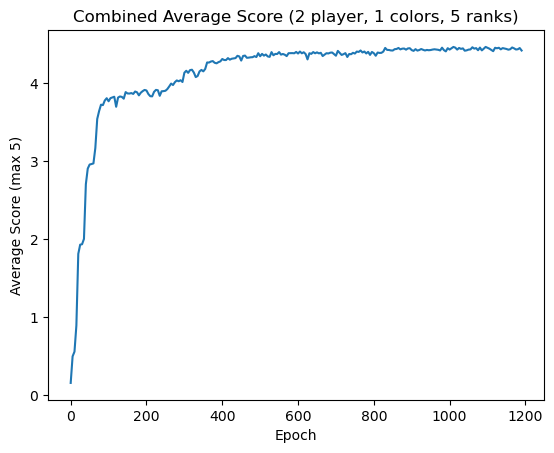

In [16]:
plot_and_save(training_history, 5)

In [19]:
print(np.mean(training_history[-20:]))

4.43857289757288
